In [3]:
# --- Core imports
import os, gc, math, warnings, time, json
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.inspection import permutation_importance
from sklearn.experimental import enable_hist_gradient_boosting  # noqa: F401
from sklearn.ensemble import HistGradientBoostingClassifier

import joblib

# --- Reproducibility
SEED = 42
np.random.seed(SEED)

DATA_DIR = r"C:\Users\Ayan\Desktop\AI project\fraud_project\data"

# --- Small helpers
def sizeof_fmt(num, suffix="B"):
    for unit in ["","K","M","G","T","P","E","Z"]:
        if abs(num) < 1024.0:
            return f"{num:3.1f}{unit}{suffix}"
        num /= 1024.0
    return f"{num:.1f}Y{suffix}"

def mem_usage(df):
    return sizeof_fmt(df.memory_usage(index=True).sum())

print("Setup OK. Numpy:", np.__version__, "| Pandas:", pd.__version__)
print("Looking for files in:", os.path.abspath(DATA_DIR))
for fn in ["train_transaction.csv","train_identity.csv","test_transaction.csv","test_identity.csv","sample_submission.csv"]:
    p = os.path.join(DATA_DIR, fn)
    print(fn, "✓" if os.path.exists(p) else "✗")


Setup OK. Numpy: 1.26.4 | Pandas: 2.2.2
Looking for files in: C:\Users\Ayan\Desktop\AI project\fraud_project\data
train_transaction.csv ✓
train_identity.csv ✓
test_transaction.csv ✓
test_identity.csv ✓
sample_submission.csv ✓


In [5]:
# Read in chunks -> but here full read with dtype downcast after load.
# Pandas will infer dtypes, we'll convert object->category and downcast numerics to save RAM.

train_tr = pd.read_csv(os.path.join(DATA_DIR, "train_transaction.csv"))
train_id = pd.read_csv(os.path.join(DATA_DIR, "train_identity.csv"))
test_tr  = pd.read_csv(os.path.join(DATA_DIR, "test_transaction.csv"))
test_id  = pd.read_csv(os.path.join(DATA_DIR, "test_identity.csv"))

print("Raw shapes:", train_tr.shape, train_id.shape, test_tr.shape, test_id.shape)

# Merge
train = train_tr.merge(train_id, how="left", on="TransactionID")
test  = test_tr.merge(test_id,  how="left", on="TransactionID")

del train_tr, train_id, test_tr, test_id; gc.collect()

print("Merged shapes:", train.shape, test.shape)
print("Train memory:", mem_usage(train), "| Test memory:", mem_usage(test))


Raw shapes: (590540, 394) (144233, 41) (506691, 393) (141907, 41)
Merged shapes: (590540, 434) (506691, 433)
Train memory: 1.9GB | Test memory: 1.6GB


In [7]:
def downcast_df(df: pd.DataFrame) -> pd.DataFrame:
    for col in df.columns:
        col_type = df[col].dtype
        if col_type == object:
            # convert to category (we will re-encode later across train+test together)
            df[col] = df[col].astype("category")
        elif str(col_type)[:3] == "int":
            df[col] = pd.to_numeric(df[col], downcast="integer")
        elif str(col_type)[:5] == "float":
            df[col] = pd.to_numeric(df[col], downcast="float")
    return df

train = downcast_df(train)
test  = downcast_df(test)
print("After downcast -> Train:", mem_usage(train), "| Test:", mem_usage(test))
train.head(3)


After downcast -> Train: 924.3MB | Test: 792.6MB


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# IEEE-CIS uses a relative time 'TransactionDT' (seconds from baseline).
# We'll convert to a pseudo datetime for time-based features.

START_DATE = pd.to_datetime("2017-12-01")
for df in [train, test]:
    df["TransactionDT"] = df["TransactionDT"].astype("int64")
    df["Date"] = START_DATE + pd.to_timedelta(df["TransactionDT"], unit="s")
    df["DT_day"] = (df["Date"] - START_DATE).dt.days
    df["DT_week"] = ((df["Date"] - START_DATE).dt.days) // 7
    df["DT_hour"] = df["Date"].dt.hour
    df["DT_wday"] = df["Date"].dt.weekday

# Drop the helper datetime to save memory (we keep engineered features)
train.drop(columns=["Date"], inplace=True)
test.drop(columns=["Date"], inplace=True)


In [11]:
for df in [train, test]:
    df["TransactionAmt_log1p"] = np.log1p(df["TransactionAmt"])
    # count missing across key groups to give the model "data completeness" signals
    null_cols = [c for c in df.columns if c not in ["isFraud"]]
    df["nulls_count"] = df[null_cols].isna().sum(axis=1).astype("int32")


In [13]:
def map_email(x):
    if pd.isna(x): return "unknown"
    x = str(x).lower()
    if "gmail" in x: return "gmail"
    if "yahoo" in x: return "yahoo"
    if "hotmail" in x or "live" in x or "outlook" in x: return "microsoft"
    if ".edu" in x: return "edu"
    if ".gov" in x: return "gov"
    return "other"

for df in [train, test]:
    for col in ["P_emaildomain","R_emaildomain"]:
        if col in df.columns:
            df[col+"_grp"] = df[col].astype(str).map(map_email).astype("category")

# DeviceInfo cleanup: keep first token (brand-ish)
for df in [train, test]:
    if "DeviceInfo" in df.columns:
        df["DeviceInfo_clean"] = df["DeviceInfo"].astype(str).str.split("/", n=1, expand=False).str[0].str.lower().astype("category")


In [15]:
# Simple combos that tend to help:
for df in [train, test]:
    # card grouping
    df["card1_bin"] = (df["card1"] // 100).astype("float32")  # coarse bucket
    # addr combo
    if "addr1" in df.columns and "addr2" in df.columns:
        df["addr1_addr2"] = (df["addr1"].astype("string") + "_" + df["addr2"].astype("string")).astype("category")


In [21]:
TARGET = "isFraud"
NA_TOKEN = "__NA__"

# 1) Ensure any lingering object columns become category first
for df in [train, test]:
    for c in df.columns:
        if df[c].dtype == object:
            df[c] = df[c].astype("category")

# 2) Collect categorical columns in each split
train_cat = [c for c in train.columns if str(train[c].dtype) == "category"]
test_cat  = [c for c in test.columns  if str(test[c].dtype)  == "category"]

# 3) Build the union of categorical columns across train/test
cat_union = sorted(set(train_cat).union(set(test_cat)))

# 4) Add any missing categorical columns to the other frame as all-missing (string, then category)
if len(set(cat_union) - set(train.columns)) > 0:
    for c in (set(cat_union) - set(train.columns)):
        train[c] = pd.Series(pd.NA, index=train.index, dtype="string").astype("category")
if len(set(cat_union) - set(test.columns)) > 0:
    for c in (set(cat_union) - set(test.columns)):
        test[c] = pd.Series(pd.NA, index=test.index, dtype="string").astype("category")

# 5) Robust category alignment across train+test with NA sentinel
for c in cat_union:
    tr = train[c].astype("string").fillna(NA_TOKEN)
    te = test[c].astype("string").fillna(NA_TOKEN)

    combined = pd.concat([tr, te], ignore_index=True)
    cats = pd.Index(combined.unique()).tolist()  # unique() already excludes NaN for string dtype

    dtype = pd.CategoricalDtype(categories=cats, ordered=False)
    train[c] = pd.Categorical(tr, dtype=dtype)
    test[c]  = pd.Categorical(te, dtype=dtype)

# 6) Convert categories to numeric codes
for df in [train, test]:
    for c in cat_union:
        df[c] = df[c].cat.codes.astype("int32")

# 7) Drop identifier-only fields that aren't predictive
DROP_COLS = ["TransactionID"]
train = train.drop(columns=[c for c in DROP_COLS if c in train.columns])
test  = test.drop(columns=[c for c in DROP_COLS if c in test.columns])

# 8) Build matrices
features = [c for c in train.columns if c != TARGET]
X = train[features]
y = train[TARGET].astype("int8")

print("Aligned categorical columns:", len(cat_union))
print("Feature count:", len(features))
print("X shape:", X.shape, "| y mean (fraud rate):", y.mean().round(4))


Aligned categorical columns: 50
Feature count: 458
X shape: (590540, 458) | y mean (fraud rate): 0.035


In [31]:
# --- Align columns across train/test (use only columns present in BOTH) ---
all_train_feats = [c for c in train.columns if c != "isFraud"]
common_features = sorted(set(all_train_feats).intersection(set(test.columns)))

dropped_from_train_only = sorted(set(all_train_feats) - set(common_features))
print(f"Using {len(common_features)} common features. Dropped {len(dropped_from_train_only)} train-only features.")
print("Sample dropped:", dropped_from_train_only[:20])

# Rebuild X, y using only common features
X = train[common_features]
y = train["isFraud"].astype("int8")

# --- Time-aware split (as before) ---
cut_day = int(train["DT_day"].quantile(0.80))
trn_idx = train["DT_day"] <= cut_day
val_idx = train["DT_day"] >  cut_day

X_tr, y_tr = X.loc[trn_idx], y.loc[trn_idx]
X_va, y_va = X.loc[val_idx], y.loc[val_idx]

print("Split by DT_day @", cut_day)
print("Train:", X_tr.shape, " Valid:", X_va.shape)
print("Fraud rate (train):", y_tr.mean().round(4), " | (valid):", y_va.mean().round(4))

# --- Train CPU-friendly HGB model ---
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import roc_auc_score
import time, json, joblib, os

hgb = HistGradientBoostingClassifier(
    learning_rate=0.05,
    max_depth=None,
    max_leaf_nodes=63,
    min_samples_leaf=80,
    max_bins=255,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=20,
    random_state=SEED,
)

start = time.time()
hgb.fit(X_tr, y_tr)
train_time = time.time() - start

va_pred = hgb.predict_proba(X_va)[:, 1]
auc = roc_auc_score(y_va, va_pred)
print(f"Model trained in {train_time:.1f}s on CPU.  Validation ROC-AUC: {auc:.5f}")

# --- Fit on full training data with common features, predict test, save submission ---
hgb_full = HistGradientBoostingClassifier(
    learning_rate=0.05,
    max_depth=None,
    max_leaf_nodes=63,
    min_samples_leaf=80,
    max_bins=255,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=20,
    random_state=SEED,
)
hgb_full.fit(X, y)

test_proba = hgb_full.predict_proba(test[common_features])[:, 1]

sub = pd.DataFrame({
    "TransactionID": pd.read_csv(os.path.join(DATA_DIR, "test_transaction.csv"))["TransactionID"],
    "isFraud": test_proba
})
sub_path = os.path.join(DATA_DIR, "submission_hgb.csv")
sub.to_csv(sub_path, index=False)
print("Saved submission:", sub_path, "| shape:", sub.shape)

# --- Save artifacts (use common_features) ---
ART = {
    "features": common_features,
    "cut_day_used_for_split": int(cut_day),
    "seed": SEED,
    "model": "HistGradientBoostingClassifier",
}
joblib.dump(hgb_full, os.path.join(DATA_DIR, "model_hgb_full.joblib"))
with open(os.path.join(DATA_DIR, "model_meta.json"), "w") as f:
    json.dump(ART, f, indent=2)
print("Artifacts saved (model_hgb_full.joblib, model_meta.json).")


Using 435 common features. Dropped 23 train-only features.
Sample dropped: ['id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_13', 'id_14', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_24']
Split by DT_day @ 141
Train: (475006, 435)  Valid: (115534, 435)
Fraud rate (train): 0.0352  | (valid): 0.0341
Model trained in 79.8s on CPU.  Validation ROC-AUC: 0.90391
Saved submission: C:\Users\Ayan\Desktop\AI project\fraud_project\data\submission_hgb.csv | shape: (506691, 2)
Artifacts saved (model_hgb_full.joblib, model_meta.json).


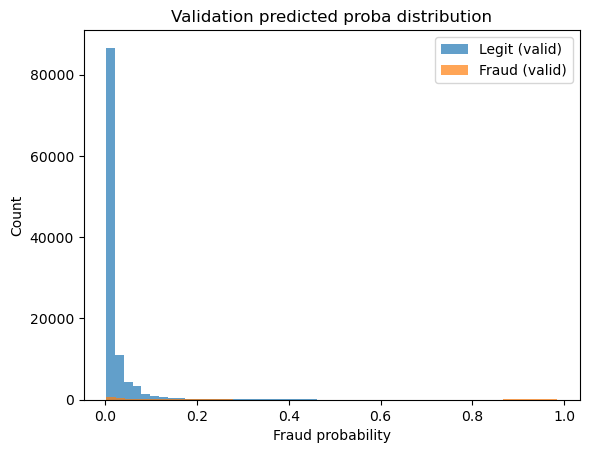

Best F1=0.5006 at threshold=0.2605


In [33]:
import matplotlib.pyplot as plt

# Score distributions on validation
plt.figure()
plt.hist(va_pred[y_va==0], bins=50, alpha=0.7, label="Legit (valid)")
plt.hist(va_pred[y_va==1], bins=50, alpha=0.7, label="Fraud (valid)")
plt.title("Validation predicted proba distribution")
plt.xlabel("Fraud probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# Threshold suggestion (maximize F1 on validation)
from sklearn.metrics import f1_score, precision_recall_curve

prec, rec, thr = precision_recall_curve(y_va, va_pred)
f1 = (2*prec*rec/(prec+rec+1e-9))
best_idx = np.nanargmax(f1)
print(f"Best F1={f1[best_idx]:.4f} at threshold={thr[best_idx]:.4f}")


In [37]:
# --- EXPORT PREPROCESSING ARTIFACTS FOR THE APP ---
import json, os, pandas as pd

DATA_DIR = r"C:\Users\Ayan\Desktop\AI project\fraud_project\data"
NA_TOKEN = "__NA__"

# Load raw (unmerged) files
train_tr = pd.read_csv(os.path.join(DATA_DIR, "train_transaction.csv"))
train_id = pd.read_csv(os.path.join(DATA_DIR, "train_identity.csv"))
test_tr  = pd.read_csv(os.path.join(DATA_DIR, "test_transaction.csv"))
test_id  = pd.read_csv(os.path.join(DATA_DIR, "test_identity.csv"))

# Merge (like notebook)
train_raw = train_tr.merge(train_id, how="left", on="TransactionID")
test_raw  = test_tr.merge(test_id,  how="left", on="TransactionID")

# Detect categorical candidates similar to what we did earlier (object + some engineered later)
for df in [train_raw, test_raw]:
    for c in df.columns:
        if df[c].dtype == object:
            df[c] = df[c].astype("category")

train_cat = [c for c in train_raw.columns if str(train_raw[c].dtype) == "category"]
test_cat  = [c for c in test_raw.columns  if str(test_raw[c].dtype)  == "category"]
cat_union = sorted(set(train_cat).union(set(test_cat)))

cat_mapping = {"NA_TOKEN": NA_TOKEN, "columns": {}}
for c in cat_union:
    tr = train_raw[c].astype("string").fillna(NA_TOKEN) if c in train_raw.columns else pd.Series([], dtype="string")
    te = test_raw[c].astype("string").fillna(NA_TOKEN)  if c in test_raw.columns  else pd.Series([], dtype="string")
    combined = pd.concat([tr, te], ignore_index=True)
    cats = pd.Index(combined.unique()).tolist()
    cat_mapping["columns"][c] = cats

# Save mapping
with open(os.path.join(DATA_DIR, "cat_mapping.json"), "w") as f:
    json.dump(cat_mapping, f, indent=2)

# Save the exact feature list used by your trained model (from model_meta.json if present)
common_features = None
meta_path = os.path.join(DATA_DIR, "model_meta.json")
if os.path.exists(meta_path):
    with open(meta_path, "r") as f:
        meta = json.load(f)
    if "features" in meta:
        common_features = meta["features"]

if common_features is None:
    # fallback: intersect train/test columns excluding target
    tr_cols = set(train_raw.columns) - {"isFraud"}
    te_cols = set(test_raw.columns)
    common_features = sorted(tr_cols.intersection(te_cols))

with open(os.path.join(DATA_DIR, "common_features.json"), "w") as f:
    json.dump({"features": common_features}, f, indent=2)

print("Exported: cat_mapping.json and common_features.json")


Exported: cat_mapping.json and common_features.json
